In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan

#import plotly. as py
#import plotly.graph_objs as go
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('lines',lw=2) 

In [2]:
expt_name = 'Obsidian5'; shorthand = 'Obs5'; subfolder = 'pyplots/'

if shorthand == "Obs1": numstr = '127874'
elif shorthand == "Obs2": numstr = '127875'
elif shorthand == "Obs3": numstr = '127876'
elif shorthand == "Obs4": numstr = '127877'
elif shorthand == "Obs5": numstr = '127878'
elif shorthand == "Obs6": numstr = '129678'
elif shorthand == "ObsW": numstr = '127879'

In [3]:
COGfun = pd.read_table('COGreffiles/fun2003-2014.tab')
#COGnames = pd.read_table('COGreffiles/cognames2003-2014.tab')


df_contigorigin = pd.read_pickle(expt_name+'_contigorigin')
df = pd.read_pickle(expt_name+'maindf_AR_wellcounts')

chip = pd.read_pickle(expt_name+'ARasChip')
chip2 = pd.read_pickle(expt_name+'normalizedARasChip')
chip_abs = pd.read_pickle(expt_name+'absolutecoverageARasChip')
chip_conc = pd.read_pickle(expt_name+'DNAconcasChip')
COGassembly = pd.read_pickle(expt_name+'_COGassembly_All')
mh = pd.read_pickle(expt_name+'megahit_maindf')
mS = pd.read_pickle(expt_name+'metaSpades_maindf')
mm = pd.read_pickle(expt_name+'minimeta_maindf')
df = pd.read_pickle(expt_name+'All_maindf')

In [4]:
# select contigs that are not minimeta
def selectNotMinimeta(dataframe):
    bulk = dataframe[~dataframe['Genome ID'].str.contains('minimetagenomics')]
    return(bulk)

# select contigs that are  minimeta
def selectMinimeta(dataframe):
    mini = dataframe[dataframe['Genome ID'].str.contains('minimetagenomics')]
    return(mini)

In [5]:
def plotallphyla(df,lineage,unass):
    
    # this function starts with plotting the chip and tSNE of the entire experiment
    # then shows which is minimeta in the same configuration 
    # then cycles through all detected phyla, plotting them on the tSNE and their well presence 
    # then outputs an array containing the summed counts of df['Well counts'] per phylum 
    
    # lineage" must be a string naming one of the columns starting with "Lineage", e.g. 'Lineage Phylum' 
    
    minimeta = selectMinimeta(df)
    if unass == 'include':
        assigned_mini = minimeta
    else:
        assigned_mini = minimeta[~minimeta[lineage].str.contains('Unassigned')]
    listassigned = assigned_mini[lineage].unique()
    numspec = len(listassigned)
    counts = [];chipcount = [];gene_tot = [];contig_tot = [];length_tot = []
    countdf = pd.DataFrame(columns=[lineage[8:],'counts','chip','fractional occup.','mean_occup.','number of cells','num_contigs','length','genes'])
    countdf[lineage[8:]] = listassigned
    f,ax = plt.subplots()
    
    for i in listassigned:
        print(i)
        f,ax = plt.subplots()
        tempdf = assigned_mini[assigned_mini[lineage].str.contains(i)]
        counts.append(sum(tempdf['well_counts']))
        chip = minimetaWells(tempdf,'no','no')
        c = chip.iloc[:,1:]
        c = c[c.columns].astype(float)

        plt.subplot(221)
        sns.heatmap(c,linewidths=.5,yticklabels=rows) #
        sns.set(font_scale = 2)
        plt.yticks(rotation=0)
        #plt.show()
        
        #plt.
        # get logical heatmap
        a = np.max(c)
        a = np.max(a)
        plt.title(i)
        
        selectedclusters = minimeta[minimeta[lineage].str.contains(i)]
        invselectclust = minimeta[~minimeta[lineage].str.contains(i)]
        contigs = len(tempdf)
        contig_tot.append(contigs)
        lengthtot = np.sum(tempdf['Sequence Length']);
        length_tot.append(lengthtot)
        genetot = np.sum(tempdf['Gene Count'])
        gene_tot.append(genetot)
        
        info = [contigs,lengthtot,genetot]
        
        plt.subplot(222)
        plt.scatter(invselectclust['k5_x'],invselectclust['k5_y'],s=invselectclust['Sequence Length']/5e2, alpha=0.1)
        plt.scatter(selectedclusters['k5_x'],selectedclusters['k5_y'],s=selectedclusters['Sequence Length']/5e2, alpha=0.8)
        plt.xlim(-120,120)
        plt.ylim(-100,100)
        
        plt.text(-100,-200,'Number of contigs:      '+str(contigs)+'\n'+'Total sequence length:  '+str(lengthtot)+'\n'+'Number of genes:      '+str(genetot))
        
        plt.subplot(223)
        d = np.where(c > 0.3*a, 1,0)
        sns.heatmap(d,yticklabels=rows,linewidths=.5)
        plt.yticks(rotation=0)
        
        
        """  plt.subplot(224)
        ax.xaxis.set_visible(False) 
        ax.yaxis.set_visible(False)
        collabel=("col 1", "col 2", "col 3")
        ax.axis('tight')
        ax.axis('off')
        the_table = ax3.table(cellText=[info],colLabels=['Contigs','Length (bp)','Genes'],loc='center')
        
        dcsummary = pd.DataFrame([info],columns=['Contigs','Length (bp)','Genes'])
        f.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='center')"""
        
        
        chipcount.append(sum(sum(d)))

        f.set_figwidth(18)
        f.set_figheight(14)
        plt.show()
        
        f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_'+'minimetawells_'+lineage[8:]+':'+i+'_lowthres.png')
        plt.clf()
        f.clf()
    
    countdf['num_contigs'] = contig_tot
    countdf['length'] = length_tot
    countdf['genes'] = gene_tot
    countdf['counts'] = counts
    countdf['chip'] = chipcount
    countdf['fractional occup.'] = np.asarray(chipcount)/len(df.iloc[0,df_well_startcol:])
    countdf['mean_occup.'] = -np.log(1-countdf['fractional occup.'])
    countdf['number of cells'] = countdf['chip']+countdf['chip']*countdf['mean_occup.']
    
    return(countdf)

def plot_clusters(df,tSNEkmer, algorithm, args, kwds,subname,plot_kwds,lengthweigh):
    start_time = time.time()
    #plot_kwds = {'alpha' : 0.25,'s' : 30, 'linewidths':0}
    # weigh in contig length in clustering 
    tSNEdata = df.iloc[:,df_well_startcol-5:df_well_startcol-1]
    length = list(df.iloc[:,5]) 
    if lengthweigh == 'YES':
        scale = [5e4,1e5,1.5e5,2e5,2.5e5,3e5,3.5e5,4e5]
        multiplier = [2,3,4,5,6,7,8,9];
        multiplier = [i * 15 for i in multiplier]

        for i in range(0,len(length)):
            if length[i] > scale[7]:
                for j in range(1,multiplier[7]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[6]:
                for j in range(1,multiplier[6]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[5]:
                for j in range(1,multiplier[5]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[4]:
                for j in range(1,multiplier[4]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[3]:
                for j in range(1,multiplier[3]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[2]:
                for j in range(1,multiplier[2]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[1]:
                for j in range(1,multiplier[1]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])
            elif length[i] > scale[0]:
                for j in range(1,multiplier[0]):
                    tSNEdata = tSNEdata.append(tSNEdata.iloc[i,:])

    if tSNEkmer == 'k4':
        tSNEdata = tSNEdata.iloc[:,0:2]
    elif tSNEkmer == 'k5':
        tSNEdata = tSNEdata.iloc[:,2:]

    print(len(tSNEdata))
    
    #print(list(tSNEdata))
    labels = algorithm(*args, **kwds).fit_predict(tSNEdata)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    df['DBclusternum'] = labels[0:len(df)] #add cluster numbers to main df
    
    
    # plotting 
    f,ax = plt.subplots()
    plt.subplot(121)
    if tSNEkmer == 'k4':
        plt.scatter(tSNEdata.k4_x, tSNEdata.k4_y, c=colors, **plot_kwds)
    elif tSNEkmer == 'k5':
        plt.scatter(tSNEdata.k5_x, tSNEdata.k5_y, c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    clustnum = len(np.unique(labels[labels>-1]))
    plt.title(str(clustnum)+' clusters found by {}'.format(str(algorithm.__name__)), fontsize=22)
    #plt.text(-100, 100, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
    #plt.text(120, 100, str(clustnum)+' clusters found', fontsize=16)
    
    labels2 = labels[0:len(length)]
    
    fraclength = df.iloc[np.where(labels2>-1)[0],5].sum()/df.iloc[:,5].sum()
    fracNotlen = df.iloc[np.where(labels2==-1)[0],5].sum()/df.iloc[:,5].sum()
    fracinClust = len(labels2[labels2>-1])/len(labels2);fracNotClust = len(labels2[labels2==-1])/len(labels2);width=0.7
    inclust = [fracinClust, fraclength]
    outclust = [fracNotClust, fracNotlen]
    
    
    plt.subplot(122)
    ind = [1,2]
    plt.bar(ind,inclust,width=width,alpha=0.6)
    plt.bar(ind,outclust,bottom=inclust,width=width,color='grey',alpha=0.4)
    plt.xticks(ind, ('contigs','length'))
    plt.ylabel('Fraction clustered')
    plt.xlim(0,3)
    f.set_figwidth(17)
    f.set_figheight(8)
    plt.show()
    
    f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_'+str(algorithm.__name__)+'_clustering_'+subname+'.png')
    return(labels,df)

#len(np.unique(a[a>-1]))
#tSNE_k5[a==0]
#np.unique(a)

# a == cluster labels found by DBScan

# now cycle through all clusters, plot the relevant stuff (mention: total length, number of contigs,genes,crispr-containing contigs)
# relevant: pies of minimeta/bulk fraction, domains
# relevant: for minimeta: chip location (also for bulk? what does this even mean?)
# hbars of phyla and species (vs. length)
# tSNE cluster location, GC content

# added COG pies, this depends on importing the COG-files and executing the associated functions further downstream

def plotDBScanClusters(df,subname,COGassembly,COGfun):
    a = df['DBclusternum']
    df_well_startcol = 24
    poissoncount = [];crispcount = [];chipcount = [];gene_tot = [];
    contig_tot = [];length_tot = [];fracchipcount = [];domdom = [];
    domphylum = [];domspec = [];COG_no = [];mx = [];my = [];sx = [];sy = [];
    dbscandf = pd.DataFrame(columns=['cluster#','dominant domain',
                                     'dominant phylum','dominant species','chip counts',
                                     'fractional occup.','number of cells','num_contigs',
                                     'length','genes','CRISPRS','NoCOG','mu_x','mu_y','sig_x','sig_y'])
    dbscandf['cluster#'] = np.unique(a[a>-1])

    for i in range(0,max(a)+1):
        subset = df[a==i]
        invsubset = df[a!=i]
        crispcount.append(len(subset[subset['CRISPR'].str.contains('YES')]))
        
        
        mx.append(subset.k5_x.mean());sx.append(subset.k5_x.std())
        my.append(subset.k5_y.mean());sy.append(subset.k5_y.std())
        
        
        # assembly type pie (there is a more straightforward way, but I want to have the categories in the same color, this is one way to make that possible -though probably not the most elegant way)
        # this is based on contig count 
        domlist = ['minimetagenomics','megahit','metaSPAdes']
        barcolortype=sns.color_palette("deep", 10)
        assemtype = subset['Genome ID'].value_counts()
        barcolor = [];colnum = []

        # this is to get the domlist colors the same for every plot 
        for k in range(0,len(assemtype)):
            for j in range(0,len(domlist)):
                if assemtype.index[k] == domlist[j]:
                    colnum.append(j)
        for m in colnum:
            barcolor.append(barcolortype[m])                

        # minic = df['Genome ID'].str.contains('minimetagenomics').value_counts()
        # megac = df['Genome ID'].str.contains('megahit').value_counts()
        # metac = df['Genome ID'].str.contains('metaSPAdes').value_counts()

        fig = plt.figure()
        gs = gridspec.GridSpec(6, 3)


        ax1 = fig.add_subplot(gs[0,1])
        subset['Genome ID'].value_counts().plot(kind='pie',figsize=(21,14),legend=False,colors=barcolor)
        ax1.set_ylabel('')   




        ax2 = fig.add_subplot(gs[0,2])
        # domain pie (based on length)
        subsetDomainlengths,labels,barcolors = getLengthList(subset)
        ax2.pie(subsetDomainlengths,startangle=120,labels=labels,colors=barcolors)
        ax2.set_ylabel('')

        # this is domain hbar
        #barcolorsdom = makeColorScheme(subset,'YES')
        #ab= subset.groupby('Lineage Domain')['Sequence Length'].sum().reset_index()
        #ab = ab.sort_values('Sequence Length').reset_index()
        #ax = ab.iloc[:,2].plot(kind='barh',legend=False,logx=True,color=barcolorsdom,figsize=(21,14))

        # species hbar
        ax4 = fig.add_subplot(gs[1,2])
        temp = subset.groupby('Lineage Species')['Sequence Length'].sum().reset_index()
        temp = temp.sort_values('Sequence Length').reset_index()
        ax = temp.iloc[:,2].plot(kind='barh',legend=False,logx=True)#,color=barcolorsdom,figsize=(21,14))
        for l, x in enumerate(temp['Lineage Species']):
            ax.text(0.7,l-.1 , x, ha='right',fontsize='small')
        ax4.set_yticks([])
        ax4.set_xlim(1,1e8)
        ax4.set_xlabel('Assembled length (bp)')


        # chip location
        rows = ['A','B','C','D','E','F','G','H']
        ax5 = fig.add_subplot(gs[2,0:2])
        chip = minimetaWells(subset,'no','no')
        c = chip.iloc[:,1:]
        c = c[c.columns].astype(float)
        sns.heatmap(c,linewidths=.5,yticklabels=rows) #
        sns.set(font_scale = 2)
        #ax5.yticks(rotation=0)


        #well counts
        #counts = subset['well_counts'].sum()
        ab = np.max(c)
        ab = np.max(ab)
        d = np.where(c > 0.3*ab, 1,0)
        chipcount.append(sum(sum(d)))
        fracchipcount.append(chipcount[i]/len(df.iloc[0,df_well_startcol:]))
        poissoncorrection = -np.log(1-fracchipcount[i])
        #number of cells
        poissoncount.append(chipcount[i]+chipcount[i]*poissoncorrection)
        
        #info = [contigs,lengthtot,genetot]

        # tSNE location
        ax6 = fig.add_subplot(gs[2,2])
        ax6.scatter(invsubset['k5_x'],invsubset['k5_y'],s=invsubset['Sequence Length']/5e2, alpha=0.1)
        ax6.scatter(subset['k5_x'],subset['k5_y'],s=subset['Sequence Length']/5e2, alpha=0.8)
        ax6.set_xlim(-120,120)
        ax6.set_ylim(-100,100)



        # output df should be len(a), containing:
        b =subset['Lineage Domain'].value_counts()
        domdom.append(b.index[0])
        #dominant phylum
        b =subset['Lineage Phylum'].value_counts()
        domphylum.append(b.index[0])
        #dominant species
        b =subset['Lineage Species'].value_counts()
        domspec.append(b.index[0])
        #number of contigs
        contig_tot.append(len(subset))
        #number of genes
        gene_tot.append(subset['Gene Count'].sum())
        #total length 
        length_tot.append(subset['Sequence Length'].sum())

        # phylum hbar

        ax3 = plt.subplot(gs[1, 0])

        #ax3 = fig.add_subplot(gs[1,0])
        temp = subset.groupby('Lineage Phylum')['Sequence Length'].sum().reset_index()
        temp = temp.sort_values('Sequence Length').reset_index()
        ax = temp.iloc[:,2].plot(kind='barh',legend=False,logx=True)#,color=barcolorsdom,figsize=(21,14))
        for l, x in enumerate(temp['Lineage Phylum']):
            ax.text(0.7,l-.1 , x, ha='right',fontsize='small')
        plt.yticks([])
        plt.xlim(1,1e8)
        plt.xlabel('Assembled length (bp)')
        
        
        # pie of distribution of COG functions
        ax7 = fig.add_subplot(gs[3:6,2])  
        # search contigs of subset in COGassembly df 
        # this is searching for a specific string 
        #ghb = COGassembly[COGassembly.contig.str.contains('10002')].index

        # this is searching for all the elements in subset
        ghb = []
        IDlist = list(subset['Scaffold Name']) # contig numbers
        COGno = 0
        for k in IDlist:
            if COGassembly.contig.str.contains(str(k)).any():
                ghb.append(list(COGassembly[COGassembly.contig.str.contains(str(k))].index))
            else:
                COGno+=1
                
        COG_no.append(COGno)

        ghb = [item for sublist in ghb for item in sublist]
        ghb2 = COGassembly.function.loc[ghb]
        ghb3 = []
        for k in ghb2:
            for j in range(0,len(k)):
                ghb3.append(k[j])
        ghb4 = Counter(ghb3)
        ghb5 = pd.DataFrame.from_dict(ghb4, orient='index')
        ghb5 = ghb5.sort_values(by=0,ascending=1)
        #palette = sns.color_palette('GnBu_d', len(COGfun))
        #palette = sns.color_palette('cubehelix', len(COGfun))
        palette = sns.diverging_palette(10, 220, l=59, n=len(ghb5), center="light")
        wedgecolor = [];leg = []
        for k in range(0,len(ghb5)):
            wedgecolor.append(palette[k])
            for j in range(0,len(COGfun)):
                if COGfun.iloc[j,0] == ghb5.index[k]:
                    #leg.append(COGfun.iloc[j,0]+': '+COGfun.iloc[j,1]) #use for pie
                    leg.append(COGfun.iloc[j,1]) #use for barh

        """ghb5[0].plot(kind='pie',colors=wedgecolor,ax=ax7)#, labels=None)
        plt.legend(leg,bbox_to_anchor=(1.05, 0.95), loc=2)
        plt.ylabel('')"""
        ghb5[0].plot(kind='barh',ax=ax7)
        for k, x in enumerate(leg):
            ax7.text(-2,k-0.3 , x, ha='right',fontsize='small')
        ax7.set_xlabel('number of genes')
        ax7.set_yticks([])
        
        ax1.text(-5,0,expt_name+' cluster #: '+str(i)
            +'\n'+'Number of contigs:      '+str(contig_tot[i])
             +'\n'+'Total sequence length:  '+str(length_tot[i])
             +'\n'+'Number of genes:        '+str(gene_tot[i])
             +'\n'+'Number of CRISPRS:      '+str(crispcount[i])
             +'\n'+'Number of cells:         '+str(np.round(poissoncount[i]))
             +'\n'+'Contigs without genes:   '+str(COG_no[i]))
        
        
        gs.update(wspace=0.20, hspace=0.5)
        
        fig.set_figheight(32)
        fig.set_figwidth(20)
        fig.show()
        plt.show()
        if i < 10:
            fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_HDBScan_cluster_'+subname+'_0'+str(i)+'.png')
        else:
            fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_HDBScan_cluster_'+subname+'_'+str(i)+'.png')
        plt.clf()
        plt.clf()

    dbscandf['dominant domain'] = domdom    
    dbscandf['dominant species'] = domspec
    dbscandf['dominant phylum'] = domphylum  
    dbscandf['#CRISPRS'] = crispcount 
    dbscandf['chip'] = chipcount
    dbscandf['fractional occup.'] = fracchipcount
    dbscandf['number of cells'] = poissoncount
    dbscandf['num_contigs'] = contig_tot
    dbscandf['length'] = length_tot
    dbscandf['genes'] = gene_tot
    dbscandf['majorCOG'] = COG_no
    dbscandf['mu_x'] = mx;dbscandf['mu_y'] = my;
    dbscandf['sig_x'] = sx;dbscandf['sig_y'] = sy;
    
    return(dbscandf)
    
# this plots the abundance distribution based on the minimeta well counts 
# (i.e. doesnt make sense if your df contains bulk contigs only or sth in the like)
def plotAbundanceDist(inputdf, countname):
    f = plt.figure()
    plt.hist(inputdf['number of cells'], bins=np.logspace(-1,3,15))#*len(df.iloc[0,23
    plt.xscale('log')
    plt.ylabel(countname+' counts')
    plt.xlabel('Abundance')
    plt.title(expt_name)
    plt.show()
    f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_'+countname+'_AD.png')

    COGassembly['contig'] = COGassembly['contig'].astype(str)


# make selection from df based on function capital letter
def getDFfromCOGfunct(dataframe,COGdf,functiongroup,groupnamedf):
    # groupnamedf is the dataframe called 'COGfun' loaded above
    
    start_time = time.time()
    # subset that contains e.g. 'defense mechanisms' (V)
    defensedf = COGdf[COGdf['function'].str.contains(functiongroup)]
    idx = groupnamedf.loc[groupnamedf['# Code'] == functiongroup]
    title = groupnamedf.iloc[idx.index[0],1]

    # look where on the tSNE these occur
    sublist = []
    for i in range(0,len(defensedf)):
        sublist.append(defensedf.iloc[i,1][0:5])
    listcount = Counter(sublist) # histogram of contig occurrence 
    numcontigs = len(listcount) # number of contigs having the selected function
    contigsubset = pd.DataFrame.from_dict(listcount, orient='index')
    contigsubset = contigsubset.sort_values(by=0,ascending=1) # stuff in sorted dataframe
    intlist = contigsubset.index.astype(int)

    maindfselection = dataframe[dataframe['Scaffold Name'] == intlist[0]]
    dfjoiner = pd.DataFrame([0],columns=['funct_occurence'])
    dfjoiner.iloc[0,0] = contigsubset.iloc[0,0];k=0
    for i in range(1,len(intlist)):
        if (len(dataframe[dataframe.isin([intlist[i]]).any(1)]) > 0):
            maindfselection = maindfselection.append(dataframe[dataframe['Scaffold Name'] == intlist[i]])
        else:
            k+=1
    end_time = time.time()
    if (len(maindfselection) > 0):
        fig = plt.figure()
        gs = gridspec.GridSpec(1, 1)


        ax1 = fig.add_subplot(gs[0,0])
        dataframe.plot.scatter(x='k5_x',y='k5_y',alpha=0.5,ax=ax1)
        maindfselection.plot.scatter(x='k5_x',y='k5_y',ax=ax1,color='red',alpha=0.5)
        plt.title(title,fontsize=14)
        plt.show()
        fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_minimeta_'+title+'.png')
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    print(str(len(intlist)-k)+' out of '+str(len(intlist))+' contigs with selected function in selected dataframe')
    return(maindfselection,k)

# make selection from df based on partial or complete occurrence of search string in enzyme/gene name
def getDFfromCOGgene(dataframe,COGdf,genename,groupnamedf):
    # groupnamedf is the dataframe called 'COGfun' loaded above
    
    start_time = time.time()
    # subset that contains e.g. 'defense mechanisms' (V)
    defensedf = COGdf[COGdf['name'].str.contains(genename)]
    #idx = groupnamedf.loc[groupnamedf['# Code'] == functiongroup]
    title = genename

    # look where on the tSNE these occur
    sublist = []
    for i in range(0,len(defensedf)):
        sublist.append(defensedf.iloc[i,1][0:5])
    listcount = Counter(sublist) # histogram of contig occurrence 
    numcontigs = len(listcount) # number of contigs having the selected function
    contigsubset = pd.DataFrame.from_dict(listcount, orient='index')
    contigsubset = contigsubset.sort_values(by=0,ascending=1) # stuff in sorted dataframe
    intlist = contigsubset.index.astype(int)

    maindfselection = dataframe[dataframe['Scaffold Name'] == intlist[0]]
    dfjoiner = pd.DataFrame([0],columns=['funct_occurence'])
    dfjoiner.iloc[0,0] = contigsubset.iloc[0,0];k=0
    for i in range(1,len(intlist)):
        if (len(dataframe[dataframe.isin([intlist[i]]).any(1)]) > 0):
            maindfselection = maindfselection.append(dataframe[dataframe['Scaffold Name'] == intlist[i]])
        else:
            k+=1
    end_time = time.time()
    if (len(maindfselection) > 0):
        fig = plt.figure()
        gs = gridspec.GridSpec(1, 1)


        ax1 = fig.add_subplot(gs[0,0])
        dataframe.plot.scatter(x='k5_x',y='k5_y',alpha=0.5,ax=ax1)
        maindfselection.plot.scatter(x='k5_x',y='k5_y',ax=ax1,color='red',alpha=0.5)
        plt.title(title,fontsize=14)
        plt.show()
        fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_minimeta_'+title+'.png')
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    print(str(len(intlist)-k)+' out of '+str(len(intlist))+' contigs with selected function in selected dataframe')
    return(maindfselection,defensedf)

# this gets/sums the contig lengths per domain in a given dataframe, sorted and with names and color code for plotting 
def getLengthList(data):
    outputlist = [];names = [];colnum = [];barcolor = []
    namelist = ['Bacteria','Archaea','Unassigned','Viruses','Eukaryota']
    outputlist.append(data.loc[data['Lineage Domain'] == 'Bacteria', 'Sequence Length'].sum())
    if outputlist[0] != 0:
        names.append(namelist[0])
    outputlist.append(data.loc[data['Lineage Domain'] == 'Archaea', 'Sequence Length'].sum())
    if outputlist[1] != 0:
        names.append(namelist[1])
    outputlist.append(data.loc[data['Lineage Domain'] == 'Unassigned', 'Sequence Length'].sum())
    if outputlist[2] != 0:
        names.append(namelist[2])    
    outputlist.append(data.loc[data['Lineage Domain'] == 'Viruses', 'Sequence Length'].sum())
    if outputlist[3] != 0:
        names.append(namelist[3])
    outputlist.append(data.loc[data['Lineage Domain'] == 'Eukaryota', 'Sequence Length'].sum())
    if outputlist[4] != 0:
        names.append(namelist[4])
    output = np.array(outputlist)
    
    # this is to get the domlist colors the same for every plot 
    barcolortype=sns.color_palette("deep", len(output))
    for k in range(0,len(names)):
        for j in range(0,len(namelist)):
            if names[k] == namelist[j]:
                colnum.append(j)
    for m in colnum:
        barcolor.append(barcolortype[m])                
   
    outputidx = np.where(output!=0)[0]
    output = output[outputidx]
    
    idx = output.argsort()
    output.sort()
    names = list(np.array(names)[idx])
    barcolor = list(np.array(barcolor)[idx])
    return(output,names,barcolor)

# turn the columns with the well coordinates into something plottable - heatmap style
# e.g. plotting the double selected dataframe 'b' above into a heatmap, 8x12

#make a 8x12 dataframe
def minimetaWells(dataframe,plot,norm):
    cols = [0,1,2,3,4,5,6,7,8,9,10,11,12];rows = ['A','B','C','D','E','F','G','H']
    chip = pd.DataFrame(columns=cols)
    chip[0] = rows;
    colnames = list(df);colnames = colnames[df_well_startcol:];k=0;
    selectedcontigs = dataframe.iloc[:,df_well_startcol:]
    if norm == 'YES': # normalizing the contig fractional count to the entire chip occurrence
        for i in range(df_well_startcol,len(colnames)+df_well_startcol):
            selectedcontigs.iloc[:,k] = dataframe.iloc[:,i]/np.sum(dataframe.iloc[:,df_well_startcol:],1) #apply threshold here
            k+=1
    elif norm == 'ABS':
        for i in range(df_well_startcol,len(colnames)+df_well_startcol):
            selectedcontigs.iloc[:,k] = dataframe.iloc[:,i]*dataframe.iloc[:,5] # multiply by contig length to get absolute coverage
            k+=1
            
    for j in range(0,len(selectedcontigs)):
        subselection = selectedcontigs.iloc[j,:]
        for i in colnames:
            if j == 0:
                if 'A' in i:
                    chip.iloc[0,int(i[1:3])] = subselection[i]                    
                elif 'B' in i:
                    chip.iloc[1,int(i[1:3])] = subselection[i]
                elif 'C' in i:
                    chip.iloc[2,int(i[1:3])] = subselection[i]
                elif 'D' in i:
                    chip.iloc[3,int(i[1:3])] = subselection[i]
                elif 'E' in i:
                    chip.iloc[4,int(i[1:3])] = subselection[i]
                elif 'F' in i:
                    chip.iloc[5,int(i[1:3])] = subselection[i]
                elif 'G' in i:
                    chip.iloc[6,int(i[1:3])] = subselection[i]
                elif 'H' in i:
                    chip.iloc[7,int(i[1:3])] = subselection[i] 
            else: 
                if 'A' in i:
                    chip.iloc[0,int(i[1:3])] = chip.iloc[0,int(i[1:3])] + subselection[i]
                elif 'B' in i:
                    chip.iloc[1,int(i[1:3])] = chip.iloc[1,int(i[1:3])] + subselection[i]
                elif 'C' in i:
                    chip.iloc[2,int(i[1:3])] = chip.iloc[2,int(i[1:3])] + subselection[i]
                elif 'D' in i:
                    chip.iloc[3,int(i[1:3])] = chip.iloc[3,int(i[1:3])] + subselection[i]
                elif 'E' in i:
                    chip.iloc[4,int(i[1:3])] = chip.iloc[4,int(i[1:3])] + subselection[i]
                elif 'F' in i:
                    chip.iloc[5,int(i[1:3])] = chip.iloc[5,int(i[1:3])] + subselection[i]
                elif 'G' in i:
                    chip.iloc[6,int(i[1:3])] = chip.iloc[6,int(i[1:3])] + subselection[i]
                elif 'H' in i:
                    chip.iloc[7,int(i[1:3])] = chip.iloc[7,int(i[1:3])] + subselection[i]  
    if plot == 'ON':
        #plot the chip as a heat map
        c = chip.iloc[:,1:]
        c = c[c.columns].astype(float)
        #cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
        #sns.heatmap(c, cmap=cmap, mask=c.isnull())
        sns.heatmap(c,linewidths=.5,yticklabels=rows) #
        sns.set(font_scale = 2)
        plt.yticks(rotation=0)
        plt.show()
        
    
    return(chip)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


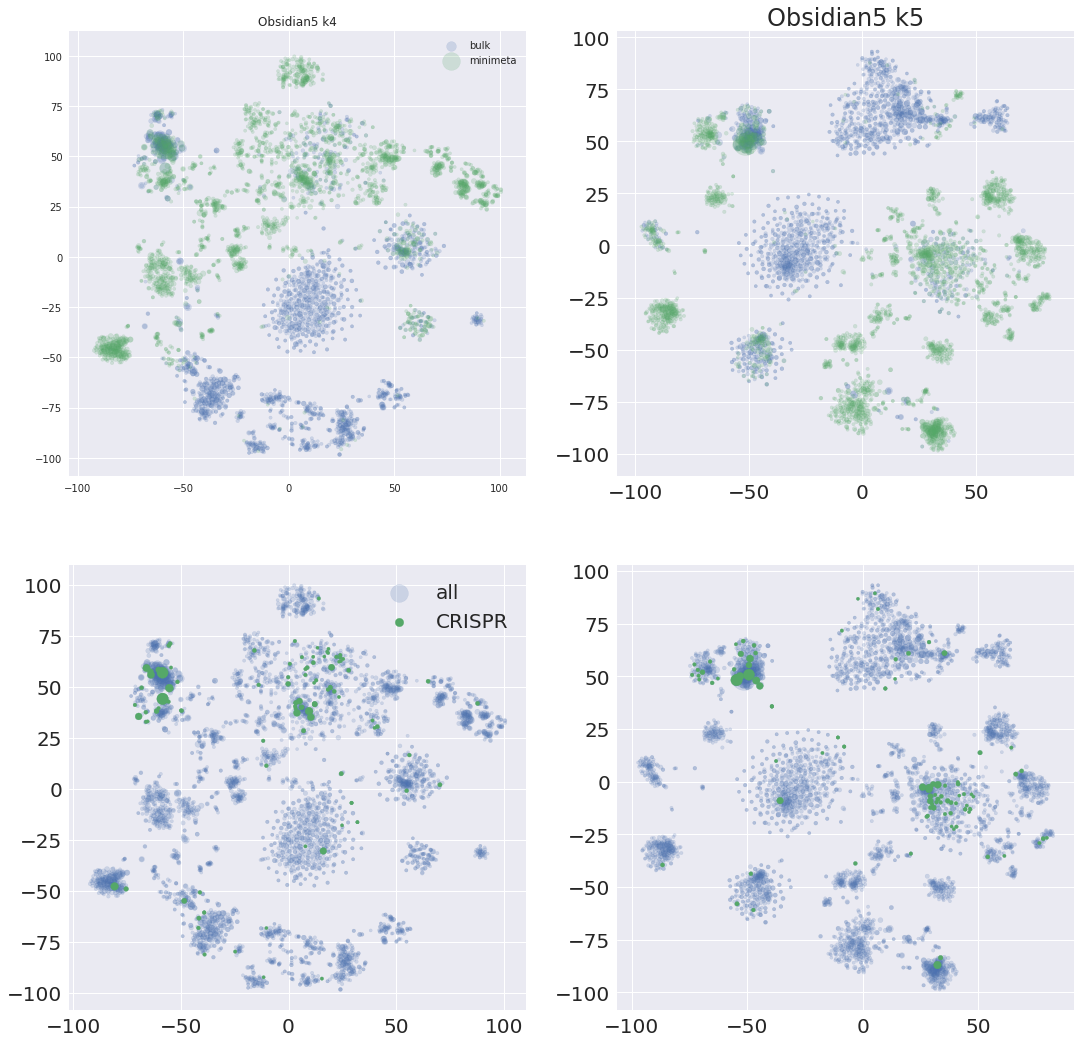

In [6]:
# tSNE all
crispr = df[df['CRISPR'].str.contains('YES')]
mini = selectMinimeta(df)
bulk = selectNotMinimeta(df)
f,ax = plt.subplots()
plt.subplot(221)
plt.scatter(bulk['k4_x'],bulk['k4_y'],s=bulk['Sequence Length']/5e2, alpha=0.2)
#plt.scatter(crispr['k4_x'],crispr['k4_y'],s=df['Sequence Length']/5e2)
plt.scatter(mini['k4_x'],mini['k4_y'],s=mini['Sequence Length']/5e2,alpha=0.2)
plt.title(expt_name+' k4')
plt.legend(['bulk','minimeta'])
legend= plt.legend(['bulk','minimeta'])
frame = legend.get_frame()
frame.set_facecolor('white')
sns.set(font_scale = 2)
plt.subplot(222)
plt.scatter(bulk['k5_x'],bulk['k5_y'],s=bulk['Sequence Length']/5e2, alpha=0.2)
#plt.scatter(crispr['k4_x'],crispr['k4_y'],s=df['Sequence Length']/5e2)
plt.scatter(mini['k5_x'],mini['k5_y'],s=mini['Sequence Length']/5e2,alpha=0.2)
plt.title(expt_name+' k5')

plt.subplot(223)
plt.scatter(df['k4_x'],df['k4_y'],s=df['Sequence Length']/5e2, alpha=0.2)
plt.scatter(crispr['k4_x'],crispr['k4_y'],s=crispr['Sequence Length']/5e2)
#plt.scatter(mini['k4_x'],mini['k4_y'],s=df['Sequence Length']/5e2,alpha=0.2)
plt.legend(['all','CRISPR'])

plt.subplot(224)
plt.scatter(df['k5_x'],df['k5_y'],s=df['Sequence Length']/5e2, alpha=0.2)
plt.scatter(crispr['k5_x'],crispr['k5_y'],s=crispr['Sequence Length']/5e2)
#plt.scatter(mini['k4_x'],mini['k4_y'],s=df['Sequence Length']/5e2,alpha=0.2)

f.set_figheight(18)
f.set_figwidth(18)
plt.show()

f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_tSNEs.png')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


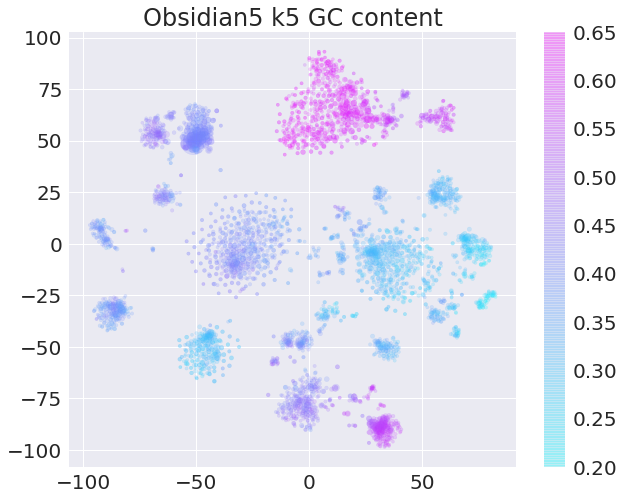

In [7]:
f,ax = plt.subplots()
cm = plt.cm.get_cmap('cool')
z = df['GC Content']
sc = plt.scatter(df['k5_x'],df['k5_y'],c=z,s=df['Sequence Length']/5e2, alpha=0.2,cmap=cm)

plt.colorbar(sc)
#plt.scatter(mini['k5_x'],mini['k5_y'],s=df['Sequence Length']/5e2,alpha=0.2)
plt.title(expt_name+' k5 GC content')

f.set_figheight(8)
f.set_figwidth(10)
plt.show()
f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_tSNEk5_GC.png')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


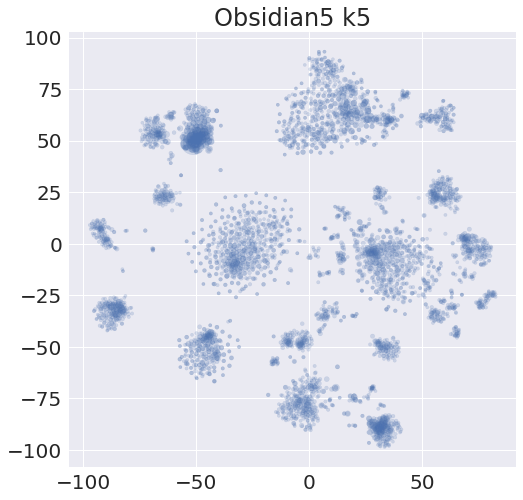

In [8]:
f,ax = plt.subplots()
plt.scatter(df['k5_x'],df['k5_y'],s=df['Sequence Length']/5e2, alpha=0.2)
#plt.scatter(mini['k5_x'],mini['k5_y'],s=df['Sequence Length']/5e2,alpha=0.2)
plt.title(expt_name+' k5')
cm = plt.cm.get_cmap('RdYlBu')
f.set_figheight(8)
f.set_figwidth(8)
plt.show()
f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_tSNEk5.png')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


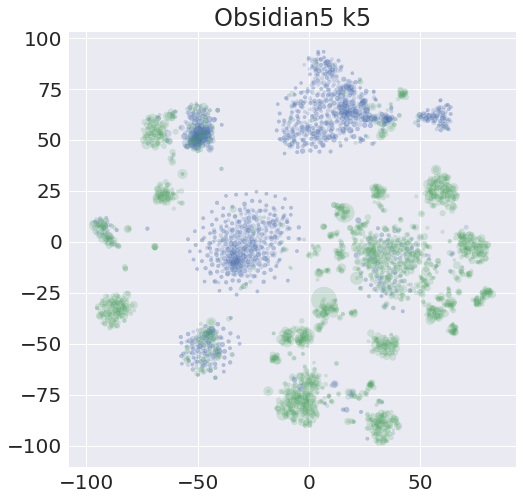

In [9]:
f,ax = plt.subplots()
plt.scatter(bulk['k5_x'],bulk['k5_y'],s=df['Sequence Length']/5e2, alpha=0.2)
plt.scatter(mini['k5_x'],mini['k5_y'],s=df['Sequence Length']/5e2,alpha=0.2)
plt.title(expt_name+' k5')

f.set_figheight(8)
f.set_figwidth(8)
plt.show()
f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_tSNEk5_minimeta.png')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


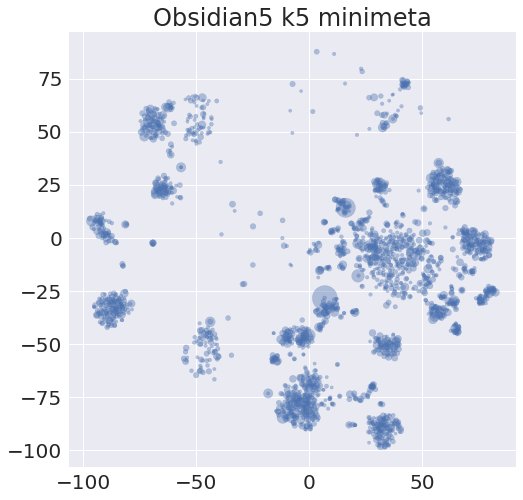

In [10]:
f,ax = plt.subplots()
plt.scatter(mini['k5_x'],mini['k5_y'],s=df['Sequence Length']/5e2,alpha=0.4)
plt.title(expt_name+' k5 minimeta')

f.set_figheight(8)
f.set_figwidth(8)
plt.show()
f.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_tSNEk5_minimetaOnly.png')

In [11]:
################################################################
################################################################
##################### Start Clustering #########################
################################################################
################################################################
df_well_startcol = 24 # the first column of the microfluidic chip series (this is used throughout as these columns are the last in the df)
sns.set(font_scale = 2)

2427


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


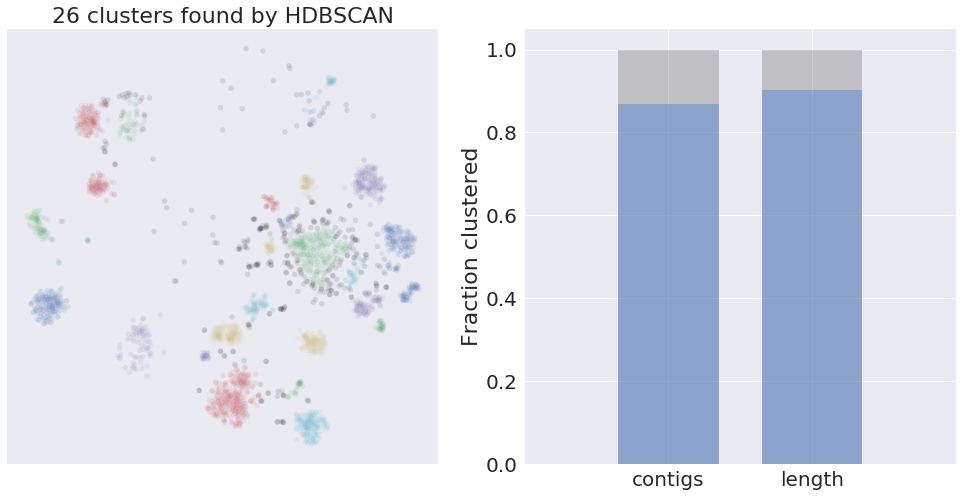

In [13]:
a_hdb, mm_hdb  = plot_clusters(mm,'k5', hdbscan.HDBSCAN, (), {'min_cluster_size':15},'minimeta_min_clust_size_10',{'alpha' : 0.1,'s' : 30, 'linewidths':0},'nope')

915


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


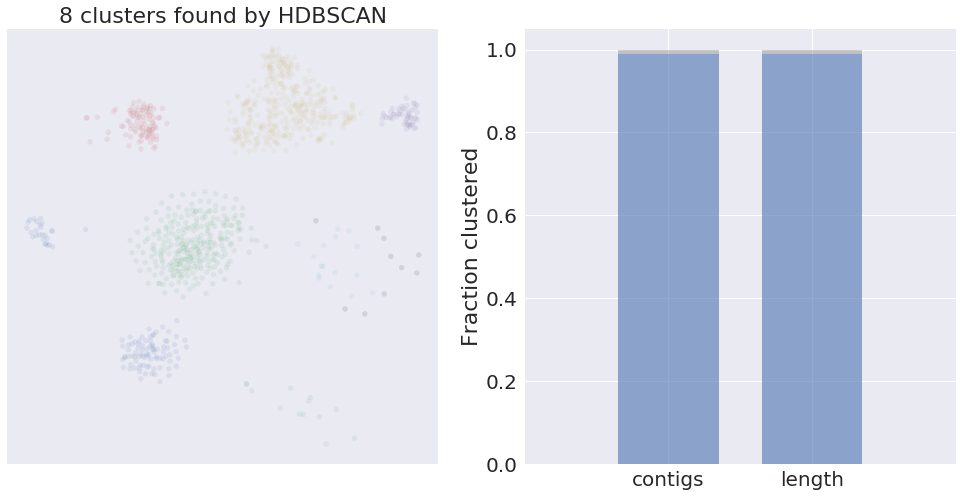

In [14]:
a_mh_hdb, mh_hdb  = plot_clusters(mh,'k5', hdbscan.HDBSCAN, (), {'min_cluster_size':5},'megahit_min_cluster_size_15',{'alpha' : 0.1,'s' : 30, 'linewidths':0},'nope') 

1059


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


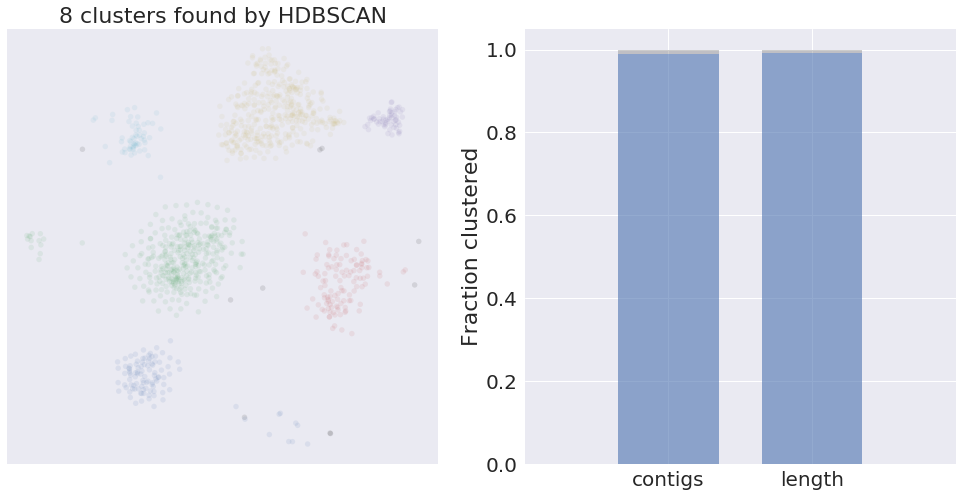

In [15]:
a_mS_hdb, mS_hdb  = plot_clusters(mS,'k5', hdbscan.HDBSCAN, (), {'min_cluster_size':10},'metaSpades_min_cluster_size_13',{'alpha' : 0.1,'s' : 30, 'linewidths':0},'nope') 

In [16]:
mm_hdb.to_pickle(expt_name+'_minimeta_HDB_maindf')
mh_hdb.to_pickle(expt_name+'_megahit_HDB_maindf')
mS_hdb.to_pickle(expt_name+'_metaSpades_HDB_maindf')

In [18]:
#clusterResult_minimeta_new = plotDBScanClusters(mm_hdb,'mini_hbar',COGassembly,COGfun)

In [20]:
#clusterResult_megahit_new = plotDBScanClusters(mh_hdb,'megahit_hbar',COGassembly,COGfun)

In [23]:
#clusterResult_metaSpades_new = plotDBScanClusters(mS_hdb,'metaSpades_hbar',COGassembly,COGfun)

In [22]:
#save dataframes for loading in next notebook
clusterResult_minimeta_new.to_pickle(expt_name+'_minimeta_HDBclusterdf')
clusterResult_megahit_new.to_pickle(expt_name+'_megahit_HDBclusterdf')
clusterResult_metaSpades_new.to_pickle(expt_name+'_metaSpades_HDBclusterdf')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


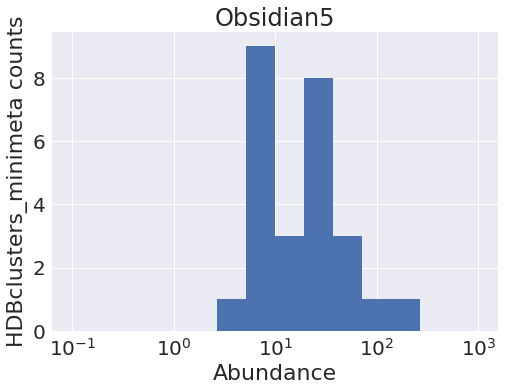

In [24]:
plotAbundanceDist(clusterResult_minimeta_new,'HDBclusters_minimeta')

In [33]:
# this is for input dataframe in the format the HDBScan cluster output dataframe 
def getrankedsummedlength_cluster(data,title,metric):
    #metric is either 'length' or 'number of cells'
    domlist = ['Bacteria','Archaea','Unassigned','Viruses','Eukaryota']
    a = data['dominant phylum']
    #letter_counts = Counter(a)
    #phyl = pd.DataFrame.from_dict(letter_counts, orient='index')
    phyl = data.sort_values(by=metric,ascending=1)
    """    phyl['dom']= '';k=0
    for i in list(phyl.index):
        idx = data.loc[data['Lineage Phylum'] == i]
        phyl.iloc[k,1] = data.loc[idx.index[0]][8]
        phyl.iloc[k,0] = data.loc[data['Lineage Phylum'] == i, 'Sequence Length'].sum()
        k+=1
    phyl = phyl.sort_values(by=0,ascending=1)"""

    
    barcolortype=sns.color_palette("deep", 10)
    
    barcolor = [];colnum = []

    # this is to get the domlist colors the same for every plot 
    for k in range(0,len(phyl)):
        for j in range(0,len(domlist)):
            if phyl.iloc[k,1] == domlist[j]:
                colnum.append(j)
                
    for m in colnum:
        barcolor.append(barcolortype[m])   
    
    
    
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 4)


    ax1 = fig.add_subplot(gs[0,1:])
    if metric == 'length':
        phyl['length'].plot(kind='barh',legend=False,color=barcolor,ax=ax1,logx=True)
        for i, x in enumerate(phyl['dominant phylum']):
            ax1.text(5e4,i-0.5 , x, ha='right',fontsize='small')
            #ax1.text(0.81,i-.1 , x, ha='right',fontsize='small')
        plt.xlabel('Assembled length (bp)')
    elif metric == 'number of cells':
        phyl['number of cells'].plot(kind='barh',legend=False,color=barcolor,ax=ax1,logx=False)
        for i, x in enumerate(phyl['dominant phylum']):
            ax1.text(-9,i-0.5 , x, ha='right',fontsize='small')
            #ax1.text(0.81,i-.1 , x, ha='right',fontsize='small')
        plt.xlabel('Number of cells')
    plt.title(title)
    plt.show()
    fig.set_figwidth(12)
    fig.set_figheight(len(phyl)/2.5)
    fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_'+title+'.png')
    
    
    return(phyl)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


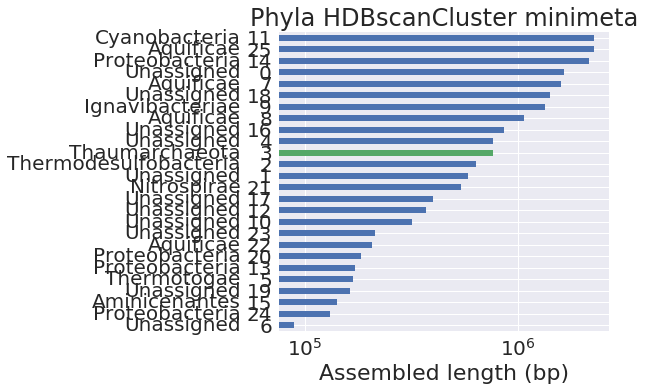

,cluster#,dominant domain,dominant phylum,dominant species,chip counts,fractional occup.,number of cells,num_contigs,length,genes,CRISPRS,NoCOG,mu_x,mu_y,sig_x,sig_y,#CRISPRS,chip,majorCOG
6,6,Bacteria,Unassigned,Unassigned,NaN,0.204301,23.342154,15,88885,97,NaN,NaN,34.619068,55.758586,2.559891,2.434778,0,19,0
24,24,Bacteria,Proteobacteria,Unassigned,NaN,0.086022,8.719586,18,131492,155,NaN,NaN,22.580847,5.765657,1.605904,2.113432,0,8,0
15,15,Bacteria,Aminicenantes,unclassified,NaN,0.075269,7.547765,21,141372,166,NaN,NaN,-15.446252,-57.200770,0.971543,1.008161,0,7,0
19,19,Bacteria,Unassigned,Unassigned,NaN,0.032258,3.098369,25,162595,194,NaN,NaN,65.026268,-43.107709,0.871897,1.479249,0,3,1
5,5,Bacteria,Thermotogae,Pseudothermotoga hypogea,NaN,0.053763,5.276313,26,167583,195,NaN,NaN,41.521635,71.645825,2.159026,2.207156,0,5,0
13,13,Bacteria,Proteobacteria,Unassigned,NaN,0.225806,26.374601,24,171552,192,NaN,NaN,26.053295,-72.147060,2.731685,2.572305,0,21,0
20,20,Bacteria,Proteobacteria,Unassigned,NaN,0.096774,9.916044,29,182932,210,NaN,NaN,14.545573,15.017535,1.836577,1.949803,0,9,0
22,22,Bacteria,Aquificae,Hydrogenobaculum sp. SHO,NaN,0.096774,9.916044,26,207706,266,NaN,NaN,14.205615,-5.851583,1.158984,1.854239,0,9,0
23,23,Bacteria,Unassigned,Unassigned,NaN,0.053763,5.276313,32,214269,221,NaN,NaN,52.690724,-18.542152,2.045115,3.224273,0,5,0
10,10,Bacteria,Unassigned,Unassigned,NaN,0.096774,9.916044,45,318966,338,NaN,NaN,31.238380,23.712153,1.518856,2.666669,0,9,2


In [34]:
getrankedsummedlength_cluster(clusterResult_minimeta_new,'Phyla HDBscanCluster minimeta','length')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


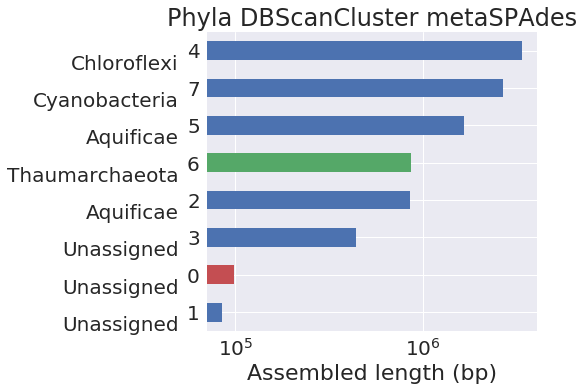

,cluster#,dominant domain,dominant phylum,dominant species,chip counts,fractional occup.,number of cells,num_contigs,length,genes,CRISPRS,NoCOG,mu_x,mu_y,sig_x,sig_y,#CRISPRS,chip,majorCOG
1,1,Bacteria,Unassigned,Unassigned,NaN,0.064516,6.400148,14,84716,89,NaN,NaN,-91.421184,6.936073,5.919632,3.381767,0,6,0
0,0,Unassigned,Unassigned,Unassigned,NaN,0.043011,4.175852,10,98113,122,NaN,NaN,11.317681,-75.580382,9.867697,5.996538,0,4,3
3,3,Bacteria,Unassigned,Unassigned,NaN,0.053763,5.276313,58,438253,380,NaN,NaN,57.626198,61.456087,4.169951,3.379609,0,5,0
2,2,Bacteria,Aquificae,Sulfurihydrogenibium sp. YO3AOP1,NaN,0.483871,74.762932,114,853428,938,NaN,NaN,38.062451,-11.644493,7.976886,10.030485,7,45,1
6,6,Archaea,Thaumarchaeota,Unassigned,NaN,0.247312,29.534398,95,860067,1091,NaN,NaN,-45.909475,-52.767618,5.882215,6.370111,1,23,0
5,5,Bacteria,Aquificae,Hydrogenobacter thermophilus,NaN,0.763441,173.350550,57,1644993,1848,NaN,NaN,-50.718699,53.581131,5.714038,6.338210,8,71,0
7,7,Bacteria,Cyanobacteria,Fischerella sp. JSC-11,NaN,0.043011,4.175852,333,2657136,2551,NaN,NaN,-28.755931,-0.728149,10.033851,10.266733,5,4,2
4,4,Bacteria,Chloroflexi,Roseiflexus sp. RS-1,NaN,0.118280,12.384683,368,3357780,3272,NaN,NaN,9.324661,64.721269,12.112553,11.267838,9,11,3


In [36]:
getrankedsummedlength_cluster(clusterResult_metaSpades_new,'Phyla DBScanCluster metaSPAdes','length')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


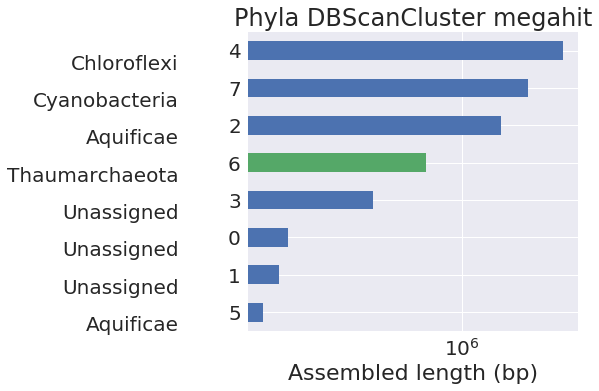

,cluster#,dominant domain,dominant phylum,dominant species,chip counts,fractional occup.,number of cells,num_contigs,length,genes,CRISPRS,NoCOG,mu_x,mu_y,sig_x,sig_y,#CRISPRS,chip,majorCOG
5,5,Bacteria,Aquificae,Unassigned,NaN,0.430108,62.492303,16,121652,138,NaN,NaN,29.535493,-9.453888,7.997558,10.429496,0,40,1
1,1,Bacteria,Unassigned,Unassigned,NaN,0.161290,17.638360,13,145117,176,NaN,NaN,14.769014,-78.862907,14.035028,9.169351,0,15,0
0,0,Bacteria,Unassigned,Unassigned,NaN,0.107527,11.137589,26,159204,171,NaN,NaN,-90.384111,5.044847,4.740820,4.160929,0,10,0
3,3,Bacteria,Unassigned,Unassigned,NaN,0.032258,3.098369,53,390874,349,NaN,NaN,58.388429,60.802211,4.139349,3.456553,0,3,2
6,6,Archaea,Thaumarchaeota,Unassigned,NaN,0.204301,23.342154,85,687465,869,NaN,NaN,-46.198026,-52.898359,6.484121,6.102618,0,19,0
2,2,Bacteria,Aquificae,Hydrogenobacter thermophilus,NaN,0.763441,173.350550,95,1511475,1733,NaN,NaN,-50.253710,57.277428,6.313210,5.691670,3,71,0
7,7,Bacteria,Cyanobacteria,Fischerella sp. JSC-11,NaN,0.086022,8.719586,277,2026880,1960,NaN,NaN,-28.523627,-1.138561,10.712288,10.865129,2,8,0
4,4,Bacteria,Chloroflexi,Roseiflexus sp. RS-1,NaN,0.150538,16.284123,340,2913826,2860,NaN,NaN,9.267130,65.511631,12.079222,12.402505,2,14,1


In [37]:
getrankedsummedlength_cluster(clusterResult_megahit_new,'Phyla DBScanCluster megahit','length')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


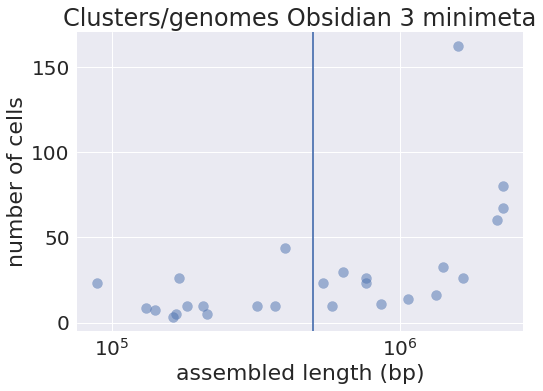

In [38]:
fig = plt.figure()
plt.scatter(clusterResult_minimeta_new.length,clusterResult_minimeta_new['number of cells'],alpha=0.5,s=100)
plt.ylabel('number of cells')
plt.xlabel('assembled length (bp)')
plt.title('Clusters/genomes Obsidian 3 minimeta')
plt.xscale('log');#plt.yscale('log')
plt.axvline(x=5e5)#,'--',color='grey')
plt.show()
fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_numcellsvslength.png')

In [39]:
################################################################
################################################################
################## From Cluster to Contour #####################
################################################################
################################################################

In [40]:
def density_estimation(m1, m2):
    from scipy import stats
    factor = 1.7
    xmin = min(m1);xmax = max(m1);ymin = min(m2);ymax = max(m2)
    xmin = xmin-abs(xmin)*factor; xmax = xmax+abs(xmax)*factor
    ymin = ymin-abs(ymin)*factor; ymax = ymax+abs(ymax)*factor
    
    X, Y = np.mgrid[xmin:xmax:350j, ymin:ymax:350j]                                            
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

def plot_density_estimation(m1,m2,plot,relcontourheight):
    X, Y, Z = density_estimation(m1, m2)
    
    
    #CS = plt.contour(X, Y, Z)                                                                           
    #dat0= CS.allsegs[0][0]
    
    
    CS = cntr.Cntr(X,Y,Z)

    # trace a contour at z == 0.5
    #res = CS.trace(0.005)
    res = CS.trace(relcontourheight*Z.max())
    #print(len(res))
    # result is a list of arrays of vertices and path codes
    # (see docs for matplotlib.path.Path)
    nseg = len(res) // 2
    #print(nseg)
    segments, codes = res[:nseg], res[nseg:]

    
    if plot == 'ON': 
        factor = 0.1
        xmin = min(m1);xmax = max(m1);ymin = min(m2);ymax = max(m2)
        xmin = xmin-abs(xmin)*factor; xmax = xmax+abs(xmax)*factor
        ymin = ymin-abs(ymin)*factor; ymax = ymax+abs(ymax)*factor
        fig, ax = plt.subplots()                   

        # Show density 
        ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax])

        # Add contour lines
        CS = plt.contour(X, Y, Z)                                                                           
        dat0= CS.allsegs[0][0]
        dat1 = CS.allsegs[1][0]
        ax.plot(m1, m2, 'k.', markersize=20,alpha=0.5)    

        ax.set_xlim([xmin-abs(xmin)*.2, xmax+abs(xmax)*.2])                                                                           
        ax.set_ylim([ymin-abs(ymin)*.2, ymax+abs(ymax)*.8])  
        fig.set_figheight(10)
        fig.set_figwidth(10)
        plt.show()
        
    return(segments,X,Y,Z)#,dat1)

from matplotlib import _cntr as cntr

def getContours(df,relcontourheight,name):
    contours = []
    factor = 0.3
    xmin = min(df.k5_x);xmax = max(df.k5_x);ymin = min(df.k5_y);ymax = max(df.k5_y)
    xmin = xmin-abs(xmin)*factor; xmax = xmax+abs(xmax)*factor
    ymin = ymin-abs(ymin)*factor; ymax = ymax+abs(ymax)*factor
    
    fig,ax = plt.subplots()
    ax.set_xlim([xmin,xmax])                                                                           
    ax.set_ylim([ymin,ymax]) 
    limits = [xmin,xmax,ymin,ymax]
    ax.scatter(df['k5_x'],df['k5_y'],color='grey',alpha=0.2,s=30)
    for i in range(0,max(df.DBclusternum)+1):
        clusterdata = df[df.DBclusternum == i]
        contour,x,y,z = plot_density_estimation(clusterdata.k5_x,clusterdata.k5_y,'off',relcontourheight)
        contour = contour[0]
        contours.append(contour)
    
        
        #plt.Polygon(contour, fill=True, color='w')
        
        ax.scatter(clusterdata['k5_x'],clusterdata['k5_y'],alpha=0.2,s=30)#color='blue',
        ax.plot(contour[:,0],contour[:,1])#,'b')
 
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.show()
    fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_contours_'+name+'.png')
    return(contours,contour,limits)

#overlay the different contourlines of two datasets 
def overlay_cluster_contours(data1,data2,limits,name):
    
    
    fig,ax = plt.subplots()
    ax.set_xlim([limits[0],limits[1]])                                                                           
    ax.set_ylim([limits[2],limits[3]]) 
    for i in range(0,len(data1)):
        temp = data1[i]
        ax.plot(temp[:,0],temp[:,1],'-b')
    for i in range(0,len(data2)):
        temp = data2[i]
        ax.plot(temp[:,0],temp[:,1],'-r',alpha=0.5)
    fig.set_figheight(10)
    fig.set_figwidth(10)    
    plt.show()
    fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_contourOverlay_'+name+'.png')
    return

# overlay the contours of the 3 assemblies
def overlay_assembly_contours(data1,data2,data3,limits,name):
    
    
    fig,ax = plt.subplots()
    ax.set_xlim([limits[0],limits[1]])                                                                           
    ax.set_ylim([limits[2],limits[3]]) 
    for i in range(0,len(data1)):
        temp = data1[i]
        ax.plot(temp[:,0],temp[:,1],'-b')
    for i in range(0,len(data2)):
        temp = data2[i]
        ax.plot(temp[:,0],temp[:,1],'-r',alpha=0.5)
    for i in range(0,len(data3)):
        temp = data3[i]
        ax.plot(temp[:,0],temp[:,1],'-g',alpha=0.5)
    fig.set_figheight(10)
    fig.set_figwidth(10)    
    plt.show()
    fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_contourOverlay_'+name+'.png')
    return

# let the contour that contains the selected COG contig in question light up
#overlay the different contourlines 
def overlay_contours_selected_contigs(data1,limits,contigselectiondf,name):
    
    
    fig,ax = plt.subplots()
    ax.set_xlim([limits[0],limits[1]])                                                                           
    ax.set_ylim([limits[2],limits[3]]) 
    for i in range(0,len(data1)):
        temp = data1[i]
        ax.plot(temp[:,0],temp[:,1],'-b')
    plt.scatter(contigselectiondf.k5_x,contigselectiondf.k5_y,color='red')
    fig.set_figheight(10)
    fig.set_figwidth(10)    
    plt.show()
    fig.savefig(subfolder+'/'+expt_name+'/'+expt_name+'_contour_selectedcontigs_'+name+'.png')
    return



/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


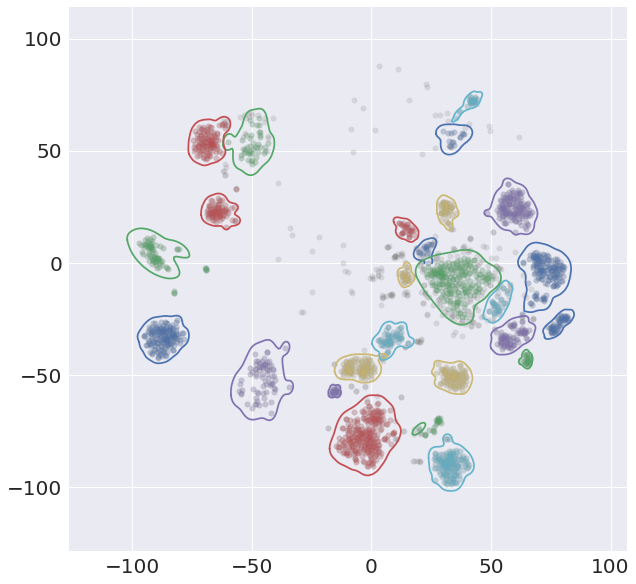

In [41]:
# compare above with HDB result
contourlines_hdb,bli_hdb,k5mini_lims = getContours(mm_hdb,0.04,'minimetaHDB')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


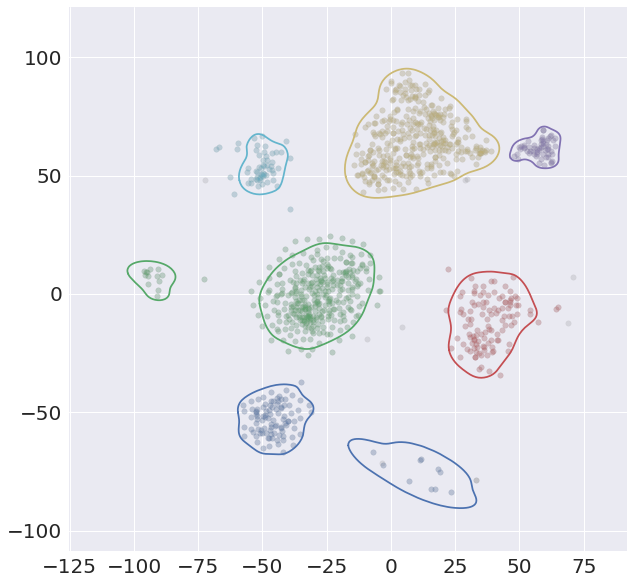

In [42]:
#metaSpades HDB scan 
contourlines_metaSpades_hdb,metaSpades_bli_hdb,k5lims = getContours(mS_hdb,0.13,'metaSpadesHDB')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


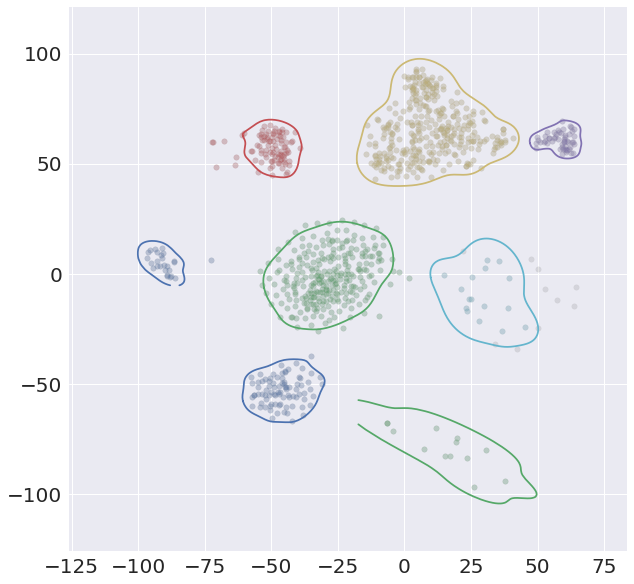

In [43]:
#metaSpades HDB scan 
contourlines_megahit_hdb,megahit_bli_hdb,k5lims = getContours(mh_hdb,0.13,'megahitHDB')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


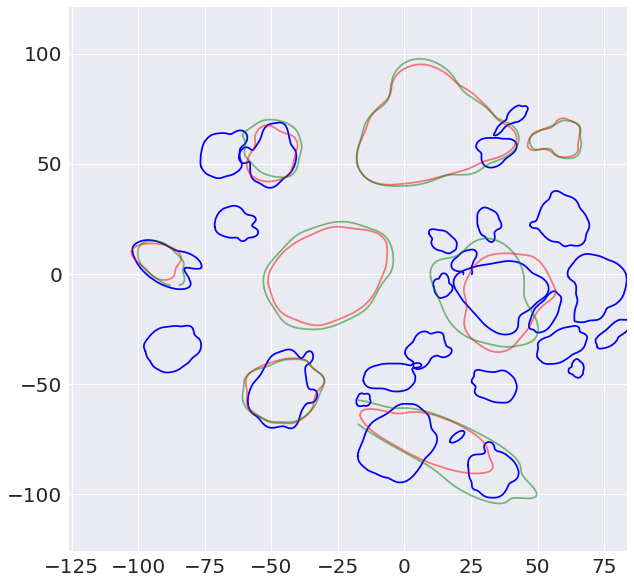

In [44]:
# compare minimeta hdb (blue) with metaSpades (red) and megahit (green)
overlay_assembly_contours(contourlines_hdb,contourlines_metaSpades_hdb,contourlines_megahit_hdb,k5lims,'MinimetavsMegahitvsMetaspades')

In [53]:
overlay_contours_selected_contigs(contourlines_hdb,k5lims,vb2,'ribosome')

NameError: name 'vb2' is not defined

In [ ]:
################################################################
################################################################
################## From Contour to Spheres #####################
################################################################
################################################################

In [45]:
#def plotClustersSpheres(clusterdf):
#clusterResult_minimeta_new.plot.scatter(x='mu_x',y='mu_y',s=300,alpha=0.5)

def plotClustersSpheres(df):
    
    factor = 0.3
    xmin = min(df.k5_x);xmax = max(df.k5_x);ymin = min(df.k5_y);ymax = max(df.k5_y)
    xmin = xmin-abs(xmin)*factor; xmax = xmax+abs(xmax)*factor
    ymin = ymin-abs(ymin)*factor; ymax = ymax+abs(ymax)*factor
    
    fig,ax = plt.subplots()
    ax.set_xlim([xmin,xmax+30])                                                                           
    ax.set_ylim([ymin,ymax]) 
    limits = [xmin,xmax,ymin,ymax]
    notinclust = df[df.DBclusternum == -1]
    #ax.scatter(notinclust['k5_x'],notinclust['k5_y'],color='grey',alpha=0.2,s=30)
    for i in range(0,max(df.DBclusternum)+1):
        clusterdata = df[df.DBclusternum == i]
        std_x = clusterdata.k5_x.std()
        std_y = clusterdata.k5_y.std()
        std = std_x+std_y
        length = clusterdata['Sequence Length'].sum()
        contigs = len(clusterdata)
        
        
        #plt.Polygon(contour, fill=True, color='w')
        
        #ax.scatter(clusterdata['k5_x'].mean(),clusterdata['k5_y'].mean(),alpha=0.5,s=contigs*30)#color='blue',
        ax.scatter(clusterdata['k5_x'].mean(),clusterdata['k5_y'].mean(),alpha=0.5,s=length/400)#color='blue',
        scale = np.array([5e4,1e5,5e5,1e6,2e6])/400
        
        #ax.plot(contour[:,0],contour[:,1])#,'b')
    ax.scatter([125,125,125,125,125],[0,10,25,47,78],s=scale,alpha=0.7,color='grey')
    plt.text(115,75,'2e6')
    plt.text(115,44,'1e6')
    plt.text(135,22,'5e5')
    plt.text(135,8,'1e5')
    plt.text(135,-3,'5e4')
    plt.title(expt_name+' HDB genomes scaled by length')
    fig.set_figheight(10)
    fig.set_figwidth(13)
    plt.show()
    return

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


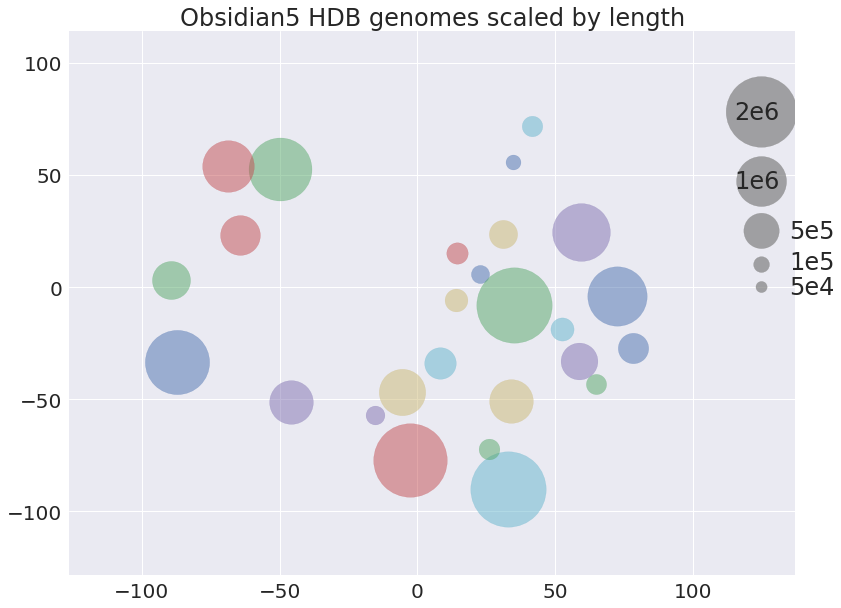

In [46]:
plotClustersSpheres(mm_hdb)

In [47]:
# plot bulk vs minimeta as spheres (but this is not fair as bulk is redundant)
f,ax = plt.subplots()
clusterResult_bulk_new.plot.scatter(x='mu_x',y='mu_y',s=[clusterResult_bulk_new.length/400],alpha=0.2,ax=ax,color='green')
clusterResult_minimeta_new.plot.scatter(x='mu_x',y='mu_y',s=[clusterResult_minimeta_new.length/400],alpha=0.5,ax=ax)
f.set_figheight(12)
f.set_figwidth(15)
ax.set_xlim(-150,170);ax.set_ylim(-120,120)
ax.set_xlabel('')
ax.set_ylabel('')
scale = np.array([1e5,5e5,1e6,5e6,1e7])/400
ax.scatter([125,125,125,125,125],[0,10,25,47,78],s=scale,alpha=0.7,color='grey')
# uncomment to add the most abundant phylum (by contig count)
"""for i in range(0,len(clusterResult_minimeta_new)):
    x = clusterResult_minimeta_new.iloc[i,12]
    y = clusterResult_minimeta_new.iloc[i,13]
    text = clusterResult_minimeta_new.iloc[i,2]
    plt.text(x,y,text,color='blue',fontsize=12)
for i in range(0,len(clusterResult_bulk_new)):
    x = clusterResult_bulk_new.iloc[i,12]
    y = clusterResult_bulk_new.iloc[i,13]
    text = clusterResult_bulk_new.iloc[i,2]
    plt.text(x,y,text,color='green',fontsize=12)"""
    
plt.text(115,75,'1e7',color='white')
plt.text(115,44,'5e6',color='white')
plt.text(135,22,'1e6',color='grey')
plt.text(135,8,'5e5',color='grey')
plt.text(135,-3,'1e5',color='grey')
plt.title(expt_name+' tSNE HDBscan bulk (green), minimeta (blue)')
f.savefig(subfolder+'/'+expt_name+'/'+expt_name+' tSNE HDBscan_bulkmini_spheres_length.png')
plt.show()

NameError: name 'clusterResult_bulk_new' is not defined

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


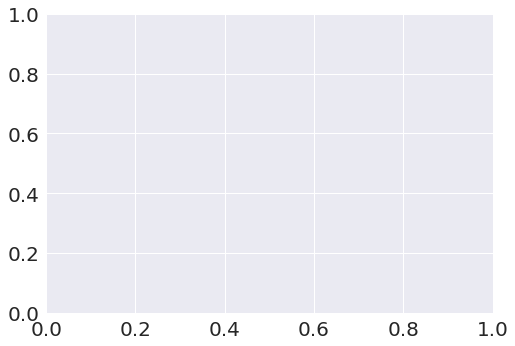

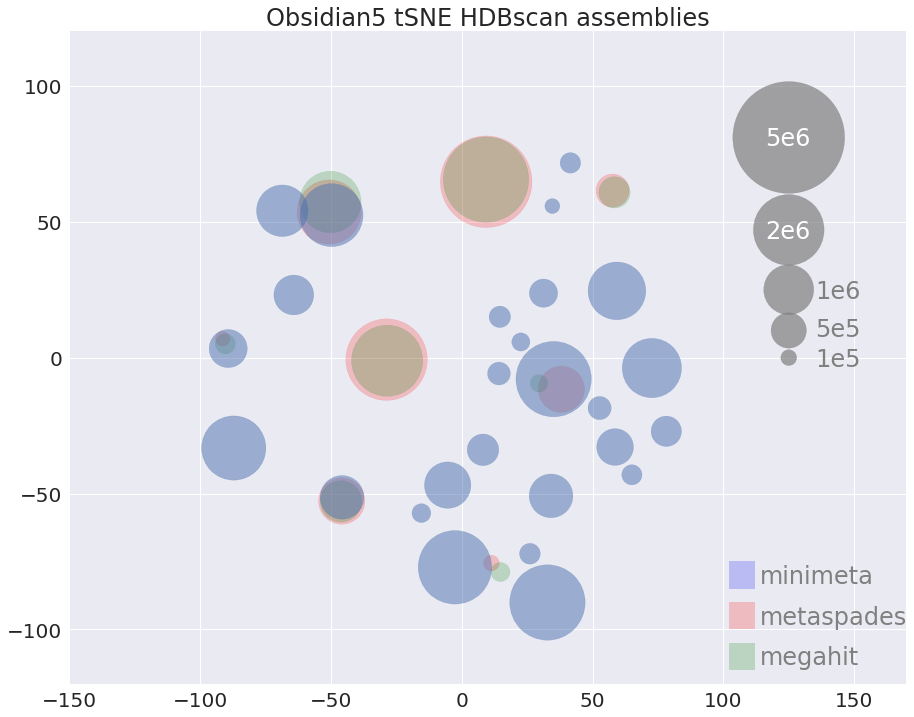

In [48]:
import matplotlib.patches as patches
# now the fair comparison: minimeta (blue), metaSpades (red), megahit (green)
f,ax = plt.subplots()
clusterResult_metaSpades_new.plot.scatter(x='mu_x',y='mu_y',s=[clusterResult_metaSpades_new.length/400],alpha=0.2,ax=ax,color='red')
clusterResult_megahit_new.plot.scatter(x='mu_x',y='mu_y',s=[clusterResult_megahit_new.length/400],alpha=0.2,ax=ax,color='green')
clusterResult_minimeta_new.plot.scatter(x='mu_x',y='mu_y',s=[clusterResult_minimeta_new.length/400],alpha=0.5,ax=ax)
f.set_figheight(12)
f.set_figwidth(15)
ax.set_xlim(-150,170);ax.set_ylim(-120,120)
ax.set_xlabel('')
ax.set_ylabel('')
scale = np.array([1e5,5e5,1e6,2e6,5e6])/400
ax.scatter([125,125,125,125,125],[0,10,25,47,81],s=scale,alpha=0.7,color='grey')
# uncomment to add the most abundant phylum (by contig count)
"""for i in range(0,len(clusterResult_minimeta_new)):
    x = clusterResult_minimeta_new.iloc[i,12]
    y = clusterResult_minimeta_new.iloc[i,13]
    text = clusterResult_minimeta_new.iloc[i,2]
    plt.text(x,y,text,color='blue',fontsize=12)
for i in range(0,len(clusterResult_bulk_new)):
    x = clusterResult_bulk_new.iloc[i,12]
    y = clusterResult_bulk_new.iloc[i,13]
    text = clusterResult_bulk_new.iloc[i,2]
    plt.text(x,y,text,color='green',fontsize=12)"""
    
plt.text(116,78,'5e6',color='white')
plt.text(116,44,'2e6',color='white')
plt.text(135,22,'1e6',color='grey')
plt.text(135,8,'5e5',color='grey')
plt.text(135,-3,'1e5',color='grey')
plt.title(expt_name+' tSNE HDBscan assemblies')

ypos1 = -85
ypos2 = -100
ypos3 = -115

ax.add_patch(
    patches.Rectangle(
        (102, ypos1),   # (x,y)
        10,          # width
        10,          # height
        facecolor = 'blue',
        alpha=0.2))

ax.add_patch(
    patches.Rectangle(
        (102, ypos2),   # (x,y)
        10,          # width
        10,          # height
        facecolor = 'red',
        alpha=0.2))

ax.add_patch(
    patches.Rectangle(
        (102, ypos3),   # (x,y)
        10,          # width
        10,          # height
        facecolor = 'green',
        alpha=0.2))

plt.text(114,ypos1+2,'minimeta',color='grey')
plt.text(114,ypos2+2,'metaspades',color='grey')
plt.text(114,ypos3+2,'megahit',color='grey')

f.savefig(subfolder+'/'+expt_name+'/'+expt_name+' tSNE HDBscan_assemblies_spheres_length.png')
plt.show()
